<a href="https://colab.research.google.com/github/pankaj-beldar/Capstone_Project_03_Corona-virus-Tweet-Sentiment-Analysis/blob/main/Capstone_03_Corona_Virus_Tweet_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import** **useful** **Libraries**

In [3]:
#let's import some useful libraries.
import pandas as pd #for Data Manipulation
import numpy as np # array
from numpy import percentile
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer #used to transform a given text into a vector
from tqdm import tqdm # used for creating Progress Meters or Progress Bars
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
!pip install nltk
import nltk
nltk.download('punkt')
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Mounting data on Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df= pd.read_csv('/content/Coronavirus Tweets.csv',encoding = 'latin')

In [6]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative


# Data Overview

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Dataset consists of 41157 entries and 6 attributes. There are no Missing values in all columns except 'Location'. The attribut 'Location' has 8590 missing values. As we want to do sentiment analysis, the 'Location' column is not so important.

In [157]:
df_null= pd.DataFrame(df.isnull().sum())
df_null.reset_index(inplace=True)
df_null

,index,0
0,UserName,0
1,ScreenName,0
2,Location,8590
3,TweetAt,0
4,OriginalTweet,0
5,Sentiment,0
6,Tweet,0
7,date,0


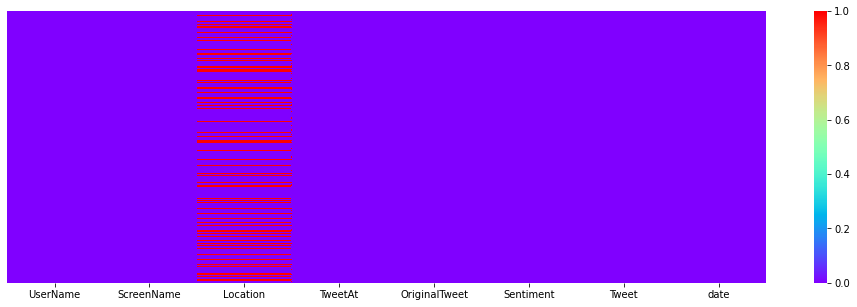

In [161]:
plt.figure(figsize=(17, 5))
sns.heatmap(df.isnull(), cmap='rainbow',cbar=True, yticklabels=False)

Null values are present in 'Location'  

In [9]:
df.shape

(41157, 6)

The dataset shape is (41157,6)

In [83]:
# Names Of columns in dataset
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment', 'Tweet', 'date'],
      dtype='object')

# **Exploratory Data Analysis**

In [163]:
#Let's check the tweet date 
df_tweetAt=pd.DataFrame(df.TweetAt.value_counts())
df_tweetAt.reset_index(inplace=True)
df_tweetAt.rename(columns={'index':'Date', 'TweetAt':'Tweet_Count'}, inplace=True)
df_tweetAt


,Date,Tweet_Count
0,20-03-2020,3448
1,19-03-2020,3215
2,25-03-2020,2979
3,18-03-2020,2742
4,21-03-2020,2653
5,22-03-2020,2114
6,23-03-2020,2062
7,17-03-2020,1977
8,08-04-2020,1881
9,07-04-2020,1843


We can see ,all tweets are from March and April month.

Text(0.5, 1.0, 'Count Plot of Tweet Date')

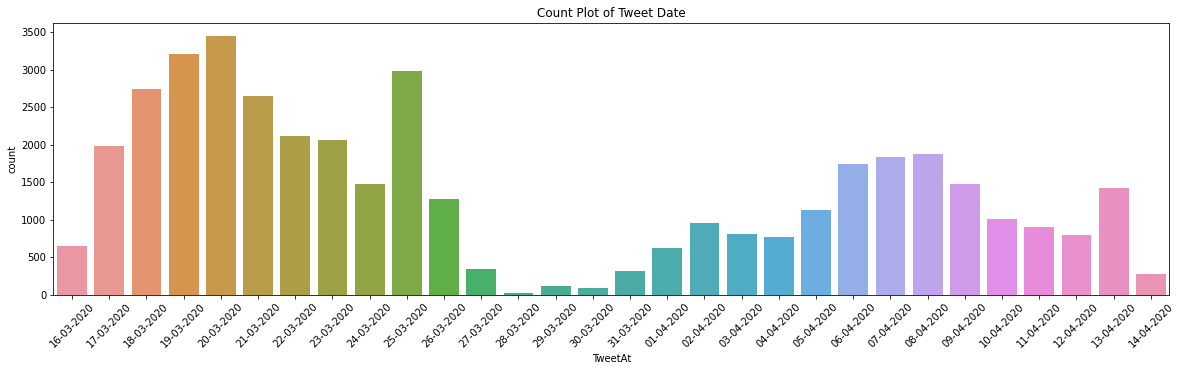

In [90]:
plt.figure(figsize=(20,5))
sns.countplot(x=df["TweetAt"])
plt.xticks(rotation=45)
plt.title('Count Plot of Tweet Date')

We can see that maximum tweets were done at 20 march 2020, when first lockdown was declared. People were more active on Tweeter in the month of March because it was the early stage of Corona virus Pandemics and people wanted to know more about this desease. 

# Top 30 Locations from where maximum tweets were done

In [115]:
# checking top 30 locations with most of the tweets
Top_30_locations=pd.DataFrame(df.Location.value_counts()[:30])
Top_30_locations.reset_index(inplace=True)
Top_30_locations.rename(columns={'index':'Location', 'Location':'Tweet_Count'}, inplace=True)
Top_30_locations

,Location,Tweet_Count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


Text(0.5, 1.0, 'Top 30 Locations with most of the tweets')

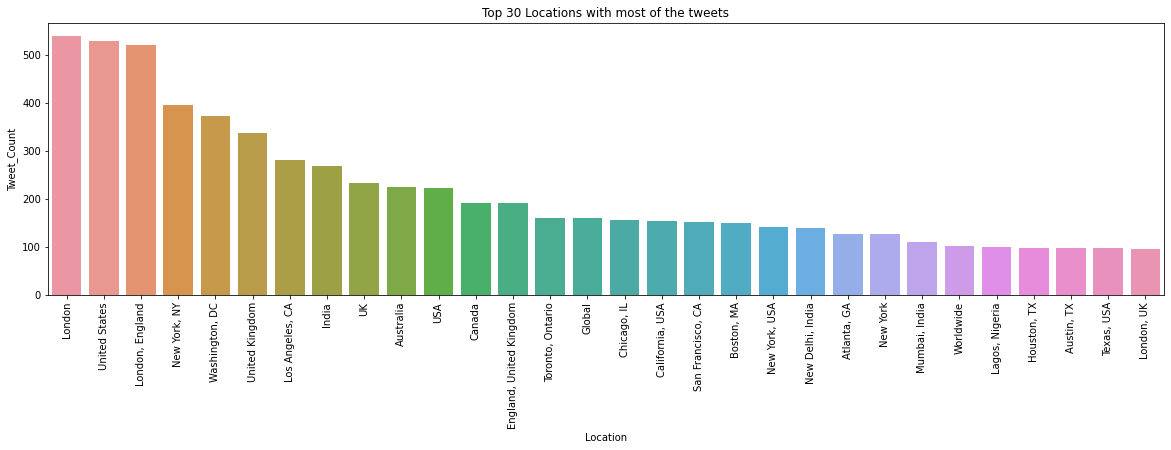

In [123]:
#barplot of top 30 locations with most of the tweets
plt.figure(figsize=(20,5))
sns.barplot(data=Top_30_locations, x='Location', y='Tweet_Count')
plt.xticks(rotation=90)
plt.title('Top 30 Locations with most of the tweets')

We can see London, United States, New York, Washington DC, United Kingdom ,India, Australia, USA are the top locations as far as count of tweets are concerned.

In [118]:
# sentiment types for classifications
df_sentiment=pd.DataFrame(df['Sentiment'].value_counts())
df_sentiment.reset_index(inplace=True)
df_sentiment.rename(columns={'index':'Sentiment', 'Sentiment':'Tweet_Count'}, inplace=True)
df_sentiment

,Sentiment,Tweet_Count
0,Positive,11422
1,Negative,9917
2,Neutral,7713
3,Extremely Positive,6624
4,Extremely Negative,5481


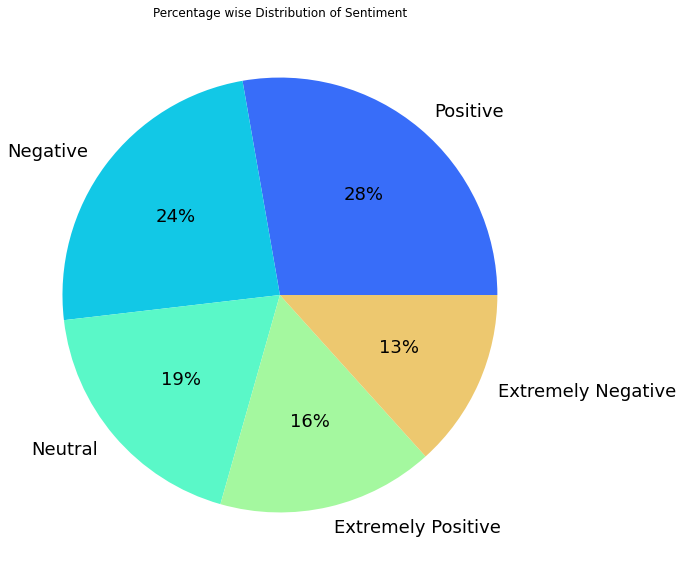

In [142]:
# finding out most frequent sentiment of the people 
plt.figure(figsize=(10,10))
keys = ['Positive','Negative','Neutral','Extremely Positive','Extremely Negative']
  
# define Seaborn color palette to use
palette_color = sns.color_palette('rainbow')
  
# plotting data on chart
plt.pie(df_sentiment['Tweet_Count'], labels=keys, colors=palette_color, autopct='%.0f%%', textprops={'fontsize': 18})
plt.title('Percentage wise Distribution of Sentiment')
# displaying chart
plt.show()


We can see, Most of the people (28% ) were having Positive sentiment about covid followed by Negative (24%), Neutral(19%), Extremely Positive (16%) and Extremely Negative(13%).

# Data Preprocessing 

In [17]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [18]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P"
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don..."


In [19]:
def remove_url(text):
  pattern =re.compile('(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*')
  return pattern.sub(r'',text)

df['Tweet']=df['Tweet'].apply(remove_url)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak"
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don..."


In [20]:
# remove short words
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [21]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths give elderly, disabled dedicated shopping hours amid COVID-19 outbreak"
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,"food stock not the only one which empty... PLEASE, don't panic, THERE WILL ENOUGH FOOD FOR EVERYONE you not take more than you need. Stay calm, stay safe. #COVID19france #COVID_19 #COVID19 #corona..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,"Me, ready supermarket during the #COVID19 outbreak. Not because I'm paranoid, but because food stock litteraly empty. The #coronavirus serious thing, but please, don't panic. causes shortage... #C..."


In [22]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
def remove_punc(text):
  return text.translate(str.maketrans(' ',' ',string.punctuation))

In [24]:
df['Tweet']=df['Tweet'].apply(remove_punc)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths give elderly disabled dedicated shopping hours amid COVID19 outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the only one which empty PLEASE dont panic THERE WILL ENOUGH FOOD FOR EVERYONE you not take more than you need Stay calm stay safe COVID19france COVID19 COVID19 coronavirus confinem...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,Me ready supermarket during the COVID19 outbreak Not because Im paranoid but because food stock litteraly empty The coronavirus serious thing but please dont panic causes shortage CoronavirusFranc...


In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
from nltk.corpus import stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [27]:
from gensim.parsing.preprocessing import remove_stopwords
df['Tweet']=df['Tweet'].apply(remove_stopwords)
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular meds order
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths elderly disabled dedicated shopping hours amid COVID19 outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock PLEASE dont panic THERE WILL ENOUGH FOOD FOR EVERYONE need Stay calm stay safe COVID19france COVID19 COVID19 coronavirus confinement Confinementotal ConfinementGeneral
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,Me ready supermarket COVID19 outbreak Not Im paranoid food stock litteraly The coronavirus thing dont panic causes shortage CoronavirusFrance restezchezvous StayAtHome confinement


In [28]:
#from textblob import TextBlob
#def correct_word(text):
#return corrected_word.correct().string

#df['Tweet']=df['Tweet'].apply(correct_word)
#df.head()

In [29]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

df['Tweet']=df['Tweet'].apply(deEmojify)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular meds order
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths elderly disabled dedicated shopping hours amid COVID19 outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock PLEASE dont panic THERE WILL ENOUGH FOOD FOR EVERYONE need Stay calm stay safe COVID19france COVID19 COVID19 coronavirus confinement Confinementotal ConfinementGeneral
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,Me ready supermarket COVID19 outbreak Not Im paranoid food stock litteraly The coronavirus thing dont panic causes shortage CoronavirusFrance restezchezvous StayAtHome confinement


In [30]:
df['Tweet']=df['Tweet'].str.lower()
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular meds order
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronavirus australia woolworths elderly disabled dedicated shopping hours amid covid19 outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock please dont panic there will enough food for everyone need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,me ready supermarket covid19 outbreak not im paranoid food stock litteraly the coronavirus thing dont panic causes shortage coronavirusfrance restezchezvous stayathome confinement


In [31]:
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [32]:
from wordcloud import WordCloud
wc = WordCloud(width=700,height=600,min_font_size=10,background_color='white')

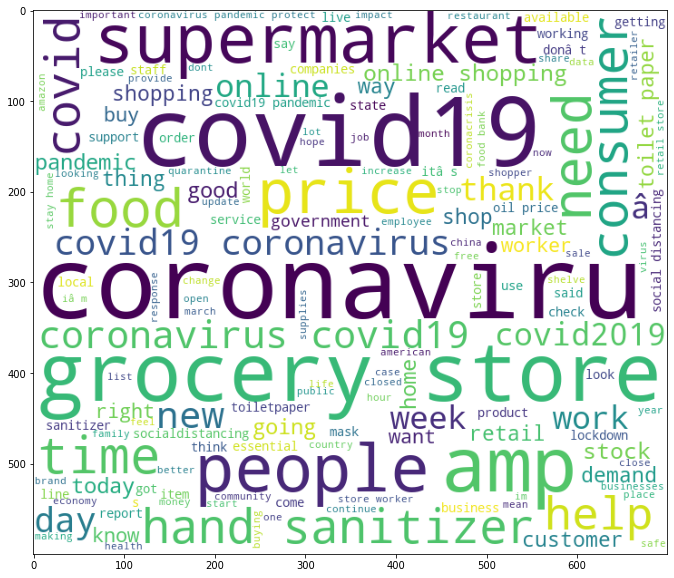

In [33]:
positive_tweet = wc.generate(df[df['Sentiment'] == 'Positive']['Tweet'].str.cat(sep=" "))
plt.figure(figsize=(20,10))
plt.imshow(positive_tweet)

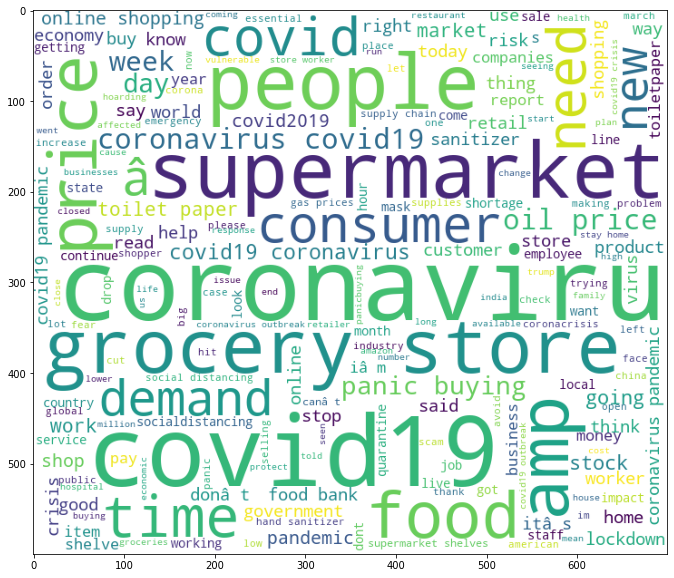

In [34]:
negative_tweet = wc.generate(df[df['Sentiment'] == 'Negative']['Tweet'].str.cat(sep=" "))
plt.figure(figsize=(20,10))
plt.imshow(negative_tweet)

In [35]:
positive_corpus = []
for msg in df[df['Sentiment'] == 'Positive']['Tweet'].tolist():
    for word in msg.split():
        positive_corpus.append(word)

len(positive_corpus)       

196141

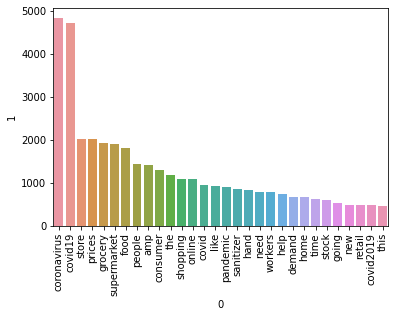

In [36]:
from collections import Counter
sns.barplot(pd.DataFrame(Counter(positive_corpus).most_common(30))[0],pd.DataFrame(Counter(positive_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [37]:
new_df = df[['Tweet','Sentiment']]

In [38]:
new_df

,Tweet,Sentiment
0,,Neutral
1,advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular meds order,Positive
2,coronavirus australia woolworths elderly disabled dedicated shopping hours amid covid19 outbreak,Positive
3,food stock please dont panic there will enough food for everyone need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral,Positive
4,me ready supermarket covid19 outbreak not im paranoid food stock litteraly the coronavirus thing dont panic causes shortage coronavirusfrance restezchezvous stayathome confinement,Extremely Negative
...,...,...
41152,airline pilots offering stock supermarket shelves nz lockdown covid19,Neutral
41153,response complaint provided citing covid19 related delays yet prompt rejecting policy consumer tat way,Extremely Negative
41154,you know itâs getting tough rationing toilet paper coronavirus toiletpaper martinsville help,Positive
41155,wrong smell hand sanitizer starting turn coronavirus covid19 coronavirus,Neutral


In [39]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)


train shape :  (32925, 2)
valid shape :  (8232, 2)


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(valid.Tweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

In [41]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

training accuracy Score    :  0.7579347000759301
Validation accuracy Score :  0.46938775510204084
                    precision    recall  f1-score   support

Extremely Negative       0.34      0.60      0.43       623
Extremely Positive       0.38      0.60      0.47       843
          Negative       0.52      0.43      0.47      2417
           Neutral       0.32      0.66      0.43       736
          Positive       0.64      0.41      0.50      3613

          accuracy                           0.47      8232
         macro avg       0.44      0.54      0.46      8232
      weighted avg       0.53      0.47      0.47      8232



In [42]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.901503416856492
Validation accuracy Score :  0.564382896015549
                    precision    recall  f1-score   support

Extremely Negative       0.65      0.59      0.62      1216
Extremely Positive       0.68      0.63      0.66      1433
          Negative       0.43      0.50      0.46      1688
           Neutral       0.76      0.58      0.66      2012
          Positive       0.44      0.53      0.48      1883

          accuracy                           0.56      8232
         macro avg       0.59      0.57      0.58      8232
      weighted avg       0.59      0.56      0.57      8232



In [43]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

Training accuracy Score    :  0.9997873955960517
Validation accuracy Score :  0.5572157434402333
                    precision    recall  f1-score   support

Extremely Negative       0.36      0.69      0.47       571
Extremely Positive       0.35      0.73      0.47       636
          Negative       0.53      0.51      0.52      2058
           Neutral       0.83      0.58      0.68      2219
          Positive       0.61      0.51      0.55      2748

          accuracy                           0.56      8232
         macro avg       0.54      0.60      0.54      8232
      weighted avg       0.61      0.56      0.57      8232



In [44]:
#takes huge amount of time to execute
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

Training accuracy Score    :  0.4378132118451025
Validation accuracy Score :  0.41897473275024294
                    precision    recall  f1-score   support

Extremely Negative       0.37      0.61      0.46       675
Extremely Positive       0.39      0.69      0.49       748
          Negative       0.32      0.48      0.38      1295
           Neutral       0.08      0.39      0.13       326
          Positive       0.78      0.34      0.48      5188

          accuracy                           0.42      8232
         macro avg       0.39      0.50      0.39      8232
      weighted avg       0.61      0.42      0.45      8232



In [45]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.9152012148823083
Validation accuracy Score :  0.5956025267249757
                    precision    recall  f1-score   support

Extremely Negative       0.45      0.71      0.55       691
Extremely Positive       0.52      0.78      0.62       880
          Negative       0.56      0.53      0.54      2116
           Neutral       0.72      0.61      0.66      1807
          Positive       0.66      0.55      0.60      2738

          accuracy                           0.60      8232
         macro avg       0.58      0.64      0.60      8232
      weighted avg       0.61      0.60      0.60      8232



In [46]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.950584662110858
Validation accuracy Score :  0.6030126336248786
                    precision    recall  f1-score   support

Extremely Negative       0.58      0.66      0.62       975
Extremely Positive       0.60      0.70      0.65      1131
          Negative       0.54      0.54      0.54      1977
           Neutral       0.72      0.63      0.67      1764
          Positive       0.59      0.57      0.58      2385

          accuracy                           0.60      8232
         macro avg       0.61      0.62      0.61      8232
      weighted avg       0.61      0.60      0.60      8232



In [47]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 16.4 MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [48]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

In [49]:
clf2 = CatBoostClassifier()


clf2.fit(X_train, y_train,  
        eval_set=(X_valid, y_valid), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
print('CatBoost model parameters:')
print(clf2.get_params())

KeyboardInterrupt: ignored

In [ ]:
catboost_prediction = clf2.predict(X_valid)
catboost_accuracy = accuracy_score(y_valid,catboost_prediction)
print("Training accuracy Score    : ",clf2.score(X_train,y_train))
print("Validation accuracy Score : ",catboost_accuracy )
print(classification_report(catboost_prediction,y_valid))

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'XGBoost','CatBoost'],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rf_accuracy, NB_accuracy, 
              sgd_accuracy, xgb_accuracy,catboost_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

# CONVRTING OUR MULTICLASS CLASSIFICATION INTO BINARY CLASSIFICATION

In [ ]:
new_df["Sentiment"]= new_df["Sentiment"].replace('Positive',1) 
new_df["Sentiment"]= new_df["Sentiment"].replace('Extremely Positive',1) 
new_df["Sentiment"]= new_df["Sentiment"].replace('Neutral',1) 
new_df["Sentiment"]= new_df["Sentiment"].replace('Negative',0) 
new_df["Sentiment"]= new_df["Sentiment"].replace('Extremely Negative',0)

In [ ]:
new_df.head()

In [ ]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(valid.Tweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))
cf_matrix= confusion_matrix(rf_prediction,y_valid)
import seaborn as sns


In [ ]:
sns.heatmap(cf_matrix, annot=True,  fmt='.2f', cmap='Blues')

In [ ]:
print(confusion_matrix(rf_prediction,y_valid))

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))


In [ ]:
clf2 = CatBoostClassifier()


clf2.fit(X_train, y_train,  
        eval_set=(X_valid, y_valid), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
print('CatBoost model parameters:')
print(clf2.get_params())

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

In [ ]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

In [ ]:
#takes huge amount of time to execute
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

In [ ]:
fig = px.bar(new_df, x='portion', y='company', template='plotly_white', orientation='h',
             labels={'portion': '% of Complaints', 'bigram': 'Bigram', 'company': 'Company'},
             color='bigram', color_discrete_sequence=px.colors.qualitative.Safe)
fig.update_layout(font=dict(size=10, color='DarkSlateGray'))
fig.update_layout(width=1200, height=500)
fig.show()